## Active Contours

<p style='direction:rtl; text-align: right'>
توجه: در کد q5.py نسخه‌ی کد همین سوال به همراه ورودی گرفتن گرافیکی‌ست.
<br><br>
این کد بر طبق روش Active Contour سعی در کاهش انرژی خم دارد که این بهینه‌سازی را با برنامه‌ریزی پویا انجام می‌دهیم.
تابع انرژی خم را به صورت زیر تعریف می‌کنیم که $v_i$ نقطه‌ای از خم است و فرض می‌کنیم مقادیر پیکسل‌ها بین صفر و یک است:
</p>


$$ E = E_{int} + E_{ext} $$

$$E_{ext} = -\gamma \sum_i^n{|\nabla I(v_i)|} \\ E_{int} = \alpha \sum_i^n{\big(|v_i-v_{i-1}|^2-\bar d\big)^2} + \beta \sum_i^n{\big(|v_i - \bar v|^2 - \frac{1}{2}\bar l\big)^2\cdot(1-sig(|\nabla I(v_i)|))}$$

$$ \bar d = \frac{1}{n} \sum_i^n{|v_i-v_{i-1}|} \quad , \quad \bar v = \frac{1}{n} \sum_i^n{v_i} \\ \bar l = \frac{1}{n} \sum_i^n{|v_i - \bar v|} \quad , \quad sig(x) = \frac{2}{1+e^{-20x}}-1$$

<p style='direction:rtl; text-align: right'>
در جمله انرژی بیرونی، تاثیر گرادیان تصویر را داریم و از آنجایی که تلاش به پیدا کردن خمی
با بالاترین گرادیان هستیم، ضریب آن را منفی در نظر می‌گیریم.
<br>
<br>
در عبارت انرژی درونی، جمله اول الاستیک بودن خم را تعیین می‌کند. این جمله از نزدیک یا دور شدن بیش از حد جلوگیری میکند
و یک نیروی مداوم برای کاهش طول خم نیز وارد می‌کند.
<br>
<br>
جمله دوم سعی در کامپکت کردن شکل باافزایش انرژی برای نقاط دور افتاده دارد
و همچنین نیروی مداومی نیز به کل خم وارد می‌کند. این جمله بسیار قدرت‌مند است و برای جلوگیری از گیر کردن خم در نقاط دور افتاده بسیار
خوب عمل میکند ولی یک نیروی مداومی نیز وارد می‌کند که می‌تواند نقاط را پس از قرار گیری روی شکل منحرف کند. بنابرین
آن را در یک تابع فعالسازی با توجه به گرادیان نقطه ضرب می‌کنیم تا تاثیر آن پس از قرار گیری روی شکل کم شود.
<br>
این تابع باعث می‌شود خم پس از برخورد با شکل، به خارج حرکت نکند ولی در عین حال روی شکل در حرکت باشد تا بر ناهمواری های شکل
منطبق شود.
<br>
<br>
پیش از اجرای الگوریتم، یک فیلتر گوسی روی تصویر اعمال می‌کنیم تا نویز کمتر شود. سپس گرادیان تصویر را به دست می‌آوریم.
اما خواهیم دید که همچنان نویز زیادی در تصویر وجود دارد مسیر برای اعمال روش هموار نیست. در اینجا با استفاده از روش Otsu
ترشهولد مناسبی برای گرادیان تصویر پیدا می‌کنیم تا تنها نقاطی با انرژی قابل توجه باقی بمانند. (روش Otsu ترشهولدی را
پیدا می‌کند که واریانس درون رده‌ای را برای دو دسته به وجود آمده، کمینه شود)
حال برای بهبود می‌توان بدون هراس از بین رفتن جزئیات مهم و ترکیب شدن آن‌ها با نویز، یک فیلتر گوسی با ضریب بالا اعمال کنیم تا
کانتور از فاصله دورتری جذب شکل شود و به سمت آن حرکت کند.
</p>

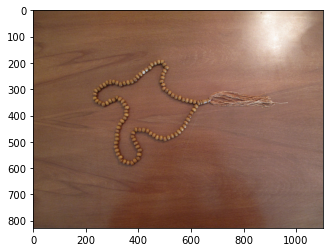

In [1]:
import numpy as np
import os
import time
import math
import ffmpeg
from matplotlib import pyplot as plt
from skimage import util, filters


def imshow(src, pts=None, line=False, width=1.5, path=None, dpi=200, tight=True):
    src = src.copy()

    if tight:
        plt.figure(dpi=dpi)
        plt.gca().set_axis_off()
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0, 0)

    plt.imshow(src)
    if pts is not None:
        pts = np.array(pts)
        pts = np.concatenate((pts, pts[0][None, :]), axis=0)
        pts = pts.T.astype(int)
        if line:
            plt.plot(pts[1], pts[0], '-', lw=width)
        plt.plot(pts[1], pts[0], '.r', markersize=1.5)

    if path is None:
        plt.show()
    else:
        plt.savefig(path, dpi=200)
        plt.close('all')


img_o = plt.imread('./data/tasbih.jpg')

plt.imshow(img_o)
plt.show()

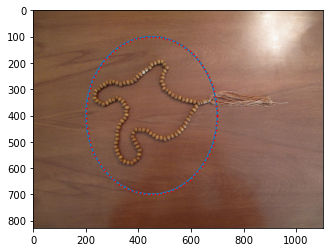

In [2]:
n = 100
s = np.linspace(0, 2 * np.pi, n)
r = 400 + 300 * np.sin(s)
c = 450 + 250 * np.cos(s)  # 580 400
init = np.array([r, c]).T

imshow(img_o ,init, line=True, dpi=100 ,tight=False)

<p style='direction:rtl; text-align: right'>
در ادامه می‌توانید تاثیر روش Otsu و فیلتر گوسی بر گرادیان را ببینید:
</p>

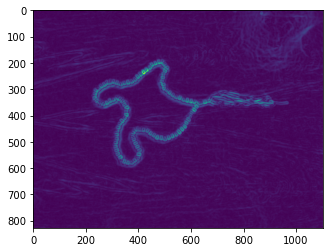

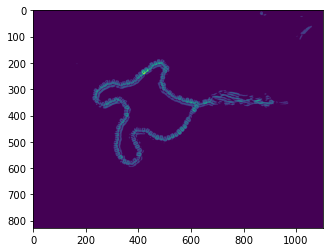

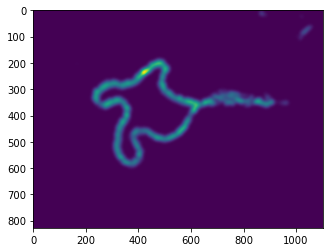

In [3]:
img = util.img_as_float64(img_o, True)
img = filters.gaussian(img, 3, multichannel=True)

img_gr = np.zeros(img.shape[:2])
for i in range(3):
    gry = filters.sobel_h(img[..., i])
    grx = filters.sobel_v(img[..., i])
    img_gr += np.sqrt(grx ** 2 + gry ** 2)

imshow(img_gr, tight=False)

thr = filters.threshold_otsu(img_gr)
img_gr *= img_gr > thr
imshow(img_gr, tight=False)

img_gr = filters.gaussian(img_gr, 7)
img_gr /= img_gr.max(initial=1e-12)
imshow(img_gr, tight=False)

<p style='direction:rtl; text-align: right'>
قطعه کد زیر الگوریتم را اجرا می‌کند و نتیجه آن را به صورت یک سری از عکس‌ها ذخیره می‌کند
تا در نهایت به ویدیو تبدیل شوند.
</p>

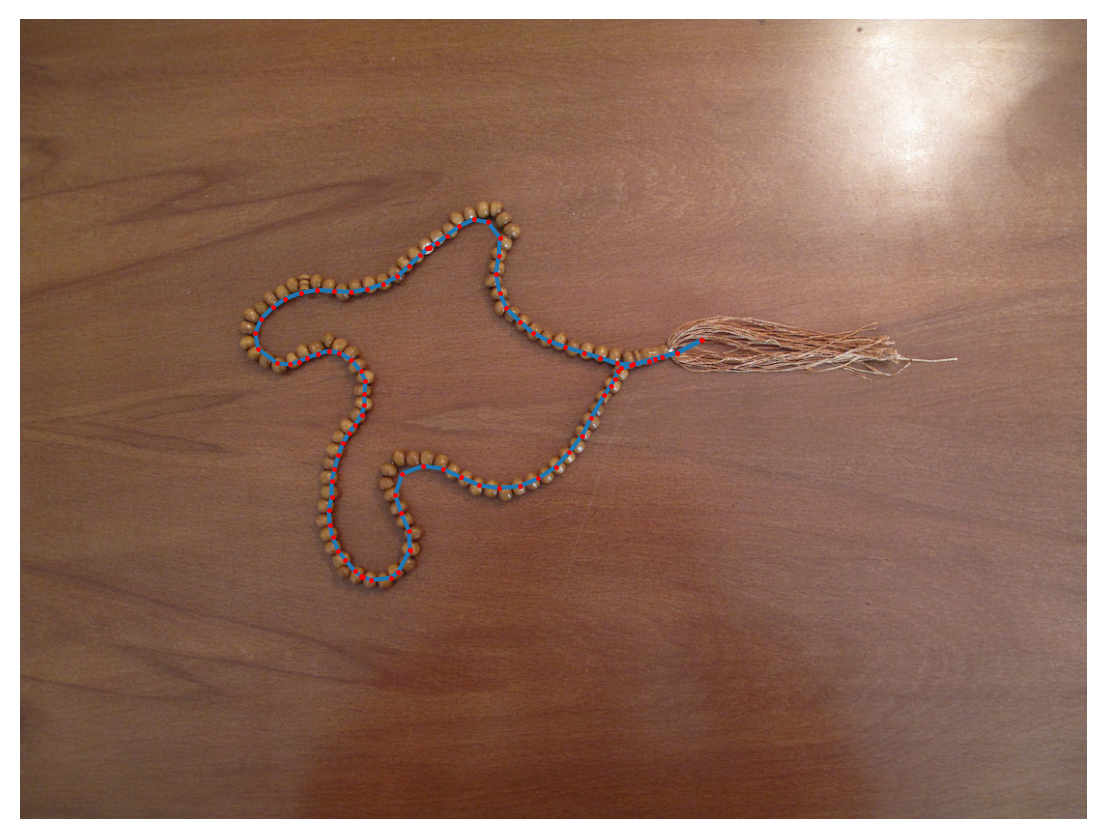

In [5]:
def sigmoid(x):
    return 2 / (1 + math.exp(-20 * x)) - 1


px_mv = 2  # maximum movement of pixels in each iteration
max_iter = 180  # maximum number of iterations
frm = 2  # capture rate

snake = init.copy()
dpx = 2 * px_mv + 1
sqpx = dpx ** 2

dir_name = str(time.time())
# os.makedirs('./out/' + dir_name)

for iter_num in range(max_iter):
    dp = np.zeros((n, sqpx))  # each entry shows energy
    dp_ref = np.zeros_like(dp, dtype=int)  # each entry shows next

    cntr = np.mean(snake, axis=0)

    alpha = 0.03 / np.linalg.norm(img.shape)
    beta = .50 / np.linalg.norm(img.shape) / n
    gamma = 1000 / n

    drv_avg = snake - np.roll(snake, 1, axis=0)
    drv_avg = np.sqrt(drv_avg[:, 0] ** 2 + drv_avg[:, 1] ** 2)
    drv_avg = np.mean(drv_avg, axis=0)

    dist_cnt_avg = snake - cntr[None, :]
    dist_cnt_avg = np.sqrt(dist_cnt_avg[:, 0] ** 2 + dist_cnt_avg[:, 1] ** 2)
    dist_cnt_avg = np.mean(dist_cnt_avg, axis=0)

    # dp optimization
    for k in range(n):
        for t1 in range(sqpx):
            cur_pt = snake[k] + (t1 / dpx - px_mv, t1 % dpx - px_mv)
            e_ext = -gamma * img_gr[tuple(cur_pt.astype(int))]
            mn = np.inf
            arg_mn = 0
            for t2 in range(sqpx):
                prev_pt = snake[k - 1] + (t2 / dpx - px_mv, t2 % dpx - px_mv)
                val = dp[k - 1, t2]
                val += alpha * (np.linalg.norm(cur_pt - prev_pt) ** 2 - drv_avg) ** 2
                if val < mn:
                    mn = val
                    arg_mn = t2
            mn += beta * (np.linalg.norm(cur_pt - cntr) ** 2 - dist_cnt_avg / 2) ** 2 * (
                    1 - sigmoid(img_gr[tuple(cur_pt.astype(int))]))
            mn += e_ext
            dp[k, t1] = mn
            dp_ref[k, t1] = arg_mn

    # update snake
    mn = np.inf
    arg_mn = 0
    for t in range(sqpx):
        if dp[n - 1, t] < mn:
            mn = dp[n - 1, t]
            arg_mn = t
    tmp = snake[n - 1] + (arg_mn / dpx - px_mv, arg_mn % dpx - px_mv)
    for k in range(n - 1):
        arg_mn = dp_ref[n - k - 1, arg_mn]
        snake[n - k - 1] = snake[n - k - 2] + (arg_mn / dpx - px_mv, arg_mn % dpx - px_mv)
    snake[0] = tmp

    if iter_num % frm == 0:
        pass
        imshow(img_o, snake, line=True, path=f'./out/{dir_name}/{iter_num:03d}.jpg')

imshow(img_o, snake, line=True)

In [ ]:
(
    ffmpeg
        .input(f'./out/{dir_name}/*.jpg', pattern_type='glob', framerate=10 / frm)
        .output(f'./out/{dir_name}/contour.mp4', crf=10)
        .run()
)
